### Cournot Duopoly

- There are two firms that interact in repeated Cournot duopoly game.
- Costs: c1,c2
- Demand: P = 1-Q

#### Cases:
- No discounting, no state
- Discounting and no state
- Discoutning and state

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Game 

In [53]:
def gameReward(c,a):
    if c>a:
        return -100
    else:
        return c**0.5

def transition(c,a,y,r):
    return max((1+r)*a+y-c,0)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### Helper Functions

In [54]:
Transition = namedtuple('Transition',('state','next_state','action','reward'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [55]:
class DQN(nn.Module):
    # Takes in a vector of states and gives out valuations for each action
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)  

In [66]:
class Agent:
    def __init__(self, N_STATES, N_ACTIONS, N_MEMORY=10000, BATCH_SIZE=512, 
                 GAMMA=0, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 1000, 
                 TAU = 0.0001, LR = 1e-5, BETA = 5, ANNEAL = 0.999, CAKE0 = 1):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.LR = LR
        self.TAU = TAU
        self.BETA0 = BETA
        self.BETA = BETA
        self.ANNEAL = ANNEAL
        self.policy_net = DQN(N_STATES,N_ACTIONS)
        self.target_net = DQN(N_STATES,N_ACTIONS)
        self.state = torch.ones(1,N_STATES)*CAKE0
        self.actions = torch.tensor(np.arange(N_ACTIONS))
        self.memory = ReplayMemory(N_MEMORY)
        self.steps_done = 0
        self.optimizer = optim.AdamW(self.policy_net.parameters(),lr=LR,amsgrad=True)
        self.action_history = []
        self.loss = torch.tensor(1000)
        
agent1 = Agent(4,2)
agent1.state

tensor([[1., 1., 1., 1.]])

In [57]:
def select_action(agent):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    eps_threshold = agent.EPS_END + (agent.EPS_START-agent.EPS_END)*math.exp(-1.*agent.steps_done/agent.EPS_DECAY)
    agent.BETA = agent.BETA0 * agent.ANNEAL ** agent.steps_done
    agent.steps_done += 1

    if sample>eps_threshold:
        with torch.no_grad():
            probs = torch.exp(agent.policy_net(agent.state)/agent.BETA)/torch.sum(torch.exp(agent.policy_net(agent.state)/agent.BETA))
            try:
                index = probs.multinomial(num_samples=1, replacement=True)
                choice = agent.actions[index]
                return torch.tensor([[choice]],dtype=torch.long)
            except: 
                randchoice = random.choice(np.arange(agent.N_ACTIONS))
                return torch.tensor([[randchoice]],dtype=torch.long)
    else:
        randchoice = random.choice(np.arange(agent.N_ACTIONS))
        return torch.tensor([[randchoice]],dtype=torch.long)
    
select_action(agent1)

tensor([[1]])

In [58]:
def update_target_net(agent):
    target_net_state_dict = agent.target_net.state_dict()
    policy_net_state_dict = agent.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU+target_net_state_dict[key]*(1-agent.TAU)
    agent.target_net.load_state_dict(target_net_state_dict)

update_target_net(agent1)

In [59]:
def optimize_model(agent):
    if len(agent.memory)<agent.BATCH_SIZE:
        return
    
    # Load data
    transitions = agent.memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = agent.policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(agent.BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*agent.GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    agent.loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    agent.optimizer.zero_grad()
    agent.loss.backward()
    torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(),100)
    agent.optimizer.step()   
    

### HyperParameters and Initializations

In [98]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
BETA = 1 # temperature of the greedy-exploratory policy
ANNEAL = 0.9 # temperature of the greedy-exploratory policy
N_MEMORY = 10000
N_STATES = 1
N_ACTIONS = 11
CAKE0 = 10
Qgrid = np.linspace(0, 1, N_ACTIONS)

agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA,
                    EPS_START, EPS_END, EPS_DECAY, TAU, 
                    LR, BETA, ANNEAL, CAKE0)

1-Qgrid, Qgrid

(array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [104]:
epochs = 100
for t in range(epochs):
    
    CAKE0 = 10
    agent1.state = CAKE0
    for i in range(10):
        print('\n Iteration:',t, 'Period',i)

        # Take action
        a1 = select_action(agent1)
        c = Qgrid[a1]

        # Obtain Reward
        r1 = gameReward(c,agent1.state)
        r1 = torch.tensor([r1])

        # Compute next state
        next_state1 = torch.maximum(agent1.state-Qgrid[a1].item(),torch.tensor(0.0))

        # store memory in transition
        agent1.memory.push(agent1.state, next_state1, a1, r1)

        # move to next state
        agent1.state = next_state1

        # optimize
        optimize_model(agent1)

        # soft update target_net
        update_target_net(agent1)

        # record actions
        agent1.action_history.append(c)

        # print loss
        print('Loss Agent 1:', agent1.loss.item(), agent1.policy_net(agent1.state).detach().numpy())



 Iteration: 0 Period 0


TypeError: linear(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
agent1.action_history

### Evaluate Networks (Convergence and Value of states)

##### Agent 1

In [38]:
# When opponent played D/0
test = torch.tensor([[0,0,0,0,0,0,0,0,0,0]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[0.6118, 0.6184, 0.6479, 0.6476, 0.6450, 0.6548, 0.6653, 0.6796, 0.6630,
          0.6648]], grad_fn=<AddmmBackward0>),
 tensor([[0.5068, 0.5129, 0.5397, 0.5424, 0.5435, 0.5492, 0.5553, 0.5717, 0.5565,
          0.5574]], grad_fn=<AddmmBackward0>))

##### Agent 2

In [39]:
# When opponent played D/0
test = torch.tensor([[1,1,1,1,1,1,1,1,1,1]], dtype = torch.float32)
agent2.policy_net(test), agent2.target_net(test)

(tensor([[0.5229, 0.4181, 0.6347, 0.4216, 0.3960, 0.5435, 0.5315, 0.6289, 0.5504,
          0.5018]], grad_fn=<AddmmBackward0>),
 tensor([[0.4271, 0.3248, 0.5424, 0.3235, 0.2975, 0.4549, 0.4367, 0.5285, 0.4484,
          0.4114]], grad_fn=<AddmmBackward0>))

### Trace Path

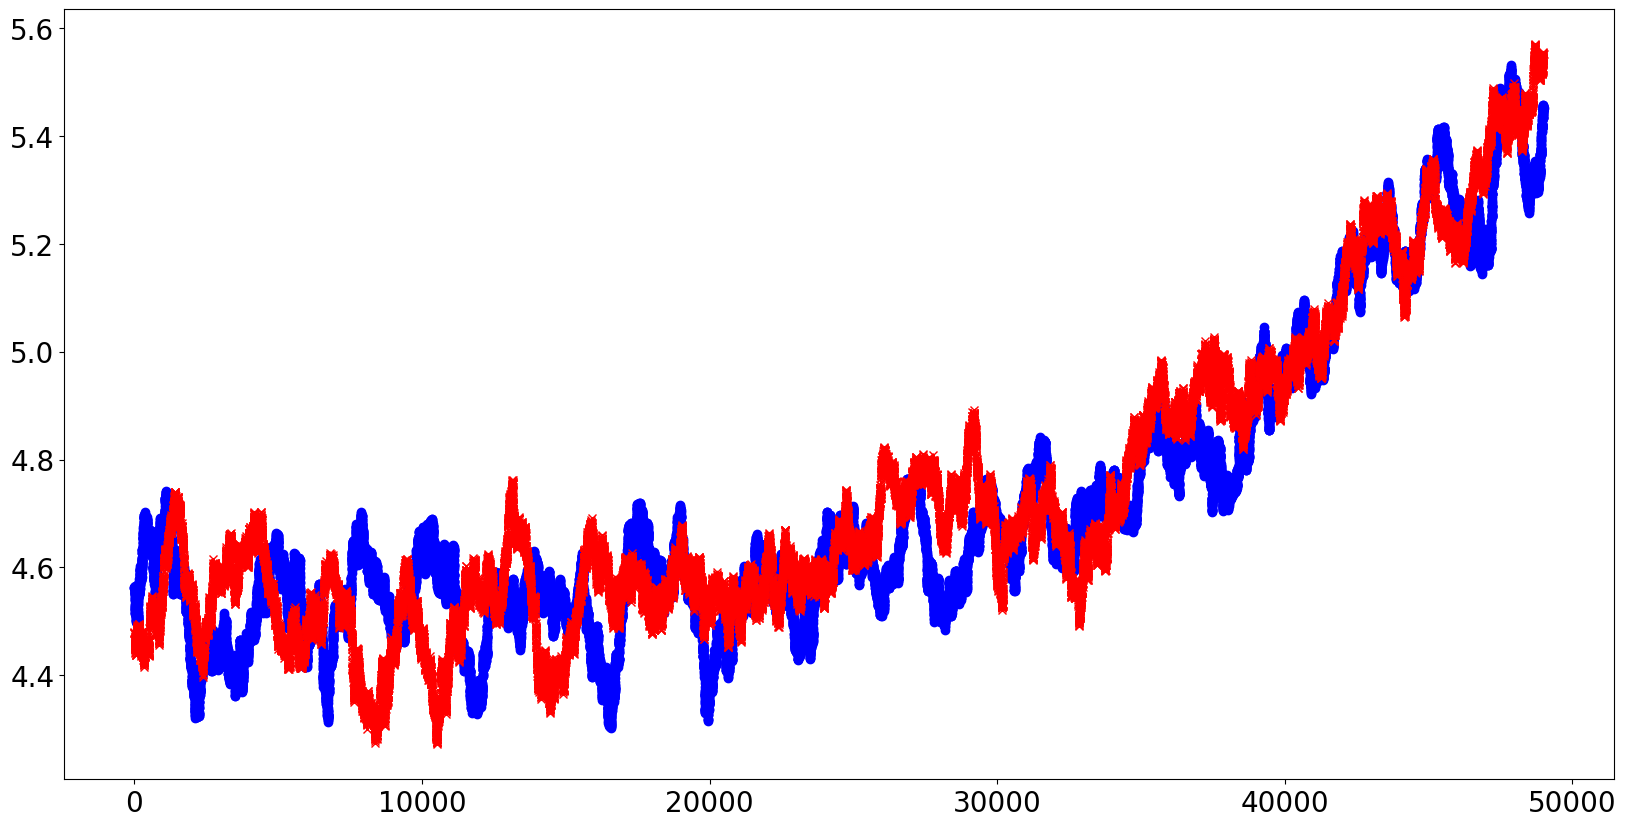

In [40]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(agent1.action_history),1000), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(agent2.action_history),1000), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()